# DQN algrorithm with BigDL

In [7]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

init_engine()

In [33]:
def get_pred(array, agent):
    prediction = agent.model.predict(sc.parallelize(array).zip(sc.parallelize([0])).map(
            lambda x: Sample.from_ndarray(x[0], x[1])))
    
    return prediction.take(1)[0]

In [38]:
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.99, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, self.action_size))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = get_pred(state, self)
        return np.argmax(act_values)  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        #local_batch.extend(minibatch)
        data_batch = []
        target_batch = []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.forward(next_state)))
            target_f = self.model.forward(state[0])
            target_f[action] = target

            data_batch.append(state[0])
            target_batch.append(target_f)
        
        batch_rdd = sc.parallelize(data_batch).zip(sc.parallelize(target_batch)).map(
            lambda x: Sample.from_ndarray(x[0], x[1]))
        
        optimizer = Optimizer(model=self.model,
                              training_rdd=batch_rdd,
                              criterion=MSECriterion(),
                              optim_method=Adam(learningrate=self.learning_rate),
                              end_trigger=MaxEpoch(1),
                              batch_size=4)
        trained_model=optimizer.optimize()
        self.model = trained_model
        self.model.evaluate()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [41]:
%%time
EPISODES=1000
conf = create_spark_conf()
conf.setMaster("local[1]")
sc = SparkContext.getOrCreate(conf)

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    done = False
    batch_size = 128
    results=[]

    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -100
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done or time == 498:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                results.append(time)
                break
            
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

[2017-11-16 16:41:15,723] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
episode: 0/1000, score: 18, e: 1.0
episode: 1/1000, score: 51, e: 1.0
episode: 2/1000, score: 10, e: 1.0
episode: 3/1000, score: 9, e: 1.0
episode: 4/1000, score: 35, e: 1.0
episode: 5/1000, score: 10, e: 1.0
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
episode: 6/1000, score: 16, e: 0.99
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
episode: 7/1000, score: 19, e: 0.98
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
episode: 8/1000, score: 36, e: 0.97
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
episode: 9/1000, score: 17, e: 0.96
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
epis

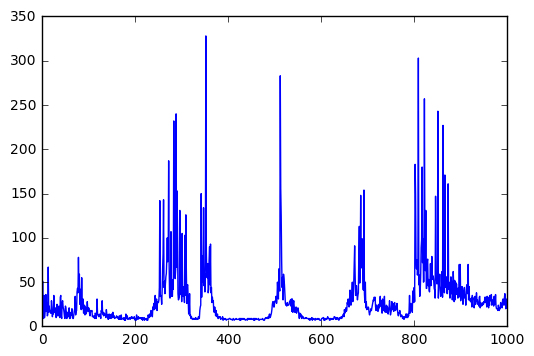

In [42]:
plt.plot(results)
plt.show()

In [43]:
state = env.reset()
done = False
while not done:
    values = agent.model.forward(state)
    print(values)
    state,_, done, _ = env.step(np.argmax(values))

[-17.24607277 -21.1901474 ]
[-17.87919998 -19.4160881 ]
[-19.91220093 -19.55477524]
[-18.08315468 -19.516716  ]
[-20.15510941 -19.74132729]
[-18.40693665 -19.66389465]
[-20.5290432 -20.0087204]
[-18.87137604 -19.85971069]
[-21.04179001 -20.3631382 ]
[-19.54504013 -20.22374725]
[-21.7044239  -20.81280708]
[-20.41685295 -20.70513153]
[-22.50749207 -21.35488892]
[-21.361763   -21.30507278]
[-19.58008766 -22.13147163]
[-22.30064774 -21.91049767]
[-20.71067429 -22.52524757]
[-23.36501884 -22.6016655 ]
[-22.13895226 -23.08479309]
[-24.53191376 -23.36840248]
[-23.65239334 -23.77303314]
[-25.85651016 -24.24418259]
[-25.15227509 -24.60721016]
[-23.81100273 -25.68788147]
[-26.60913467 -25.47492981]
[-25.87864304 -26.49193192]
[-28.23522377 -26.4844265 ]


In [37]:
get_pred(state, agent)[0]

-3.275126